# The Impact of Central Clearing on Systemic Risk
<div style="text-align: right">(C) Nikolai Nowaczyk, Sharyn O'Halloran 2019</div>

At their Pittsburgh 2009 summit, the G20 agreed that most standardized derivative contracts should be cleared through central counterparties (CCPs) by the end of 2012. We study the impact of that decision on a simulated financial system.

The steps of the simulation are:

1. Generate financial systems by randomly generating the graph of trade relations and the attached derivative portfolios
2. Compute the risks induced by these derivative portfolios onto the various counterparties
3. Aggregate the risks from the level of portfolios to the level of banks
4. Aggregate the risks from the bank level to the systemic level
5. Repeat this process for all the regulations in question.

More details on the simulation can be found in our paper:

In this notebook, we explore the result data generated by the simulation.

In [1]:
import sys
import os
from collections import OrderedDict
import matplotlib as mpl
%matplotlib notebook
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import json
import pandas as pd
from ipywidgets import Dropdown, Text, HBox, Button, VBox, RadioButtons, Layout, interactive, interact, Checkbox
from IPython.display import display, clear_output

## Data Slicing & Dicing

In [2]:
# configure metrics & regulations
regulations = ['bilateral',
               'pre_cleared_AA', 'pre_cleared_AAA', 'pre_cleared_AAAA',
               'cleared_AA', 'cleared_AAA', 'cleared_AAAA',
               'repartitioned',
               'multi_pre_cleared_AA', 'multi_pre_cleared_AAA', 'multi_pre_cleared_AAAA',
               'multi_cleared_AA', 'multi_cleared_AAA', 'multi_cleared_AAAA']
regs_base = ['bilateral', 'pre_cleared', 'cleared', 'repartitioned', 'multi_pre_cleared', 'multi_cleared']
num_regs = len(regulations)
mycmap = cm.get_cmap('icefire')
reg_colors = [mycmap(1.*i/num_regs) for i in range(0,num_regs)]
metrics = ['BaselEEPE', 'CVA']

# load df_risk_systemic & compute df_sys_impact
data_folder = os.getcwd()
df_risk_systemic = pd.read_csv(os.path.join(data_folder, 'df_risk_systemic.csv'), header=[0,1])
df_sys_impact = df_risk_systemic[[(reg,metric+'_total') for reg in regulations for metric in metrics]]
df_sys_impact.index.name='FS'

# load df_risk_cp & clean up 
df_risk_cp = pd.read_csv(os.path.join(data_folder, 'df_risk_cp.csv'), header=[0,1])
df_risk_cp = df_risk_cp.rename(columns={'Unnamed: 1_level_0':''})
df_risk_cp = df_risk_cp.rename(columns={'Unnamed: 2_level_0':''})

# load npv's from bilateral system and add asset class
df_npv =  pd.read_csv(os.path.join(data_folder, 'bilateral_npv.csv'))
df_npv['FS'] = df_npv['#TradeId'].apply(lambda x : int(x.split('.')[0].split('_')[1]))
df_npv = df_npv.merge(pd.DataFrame(data={'TradeType': ['Swap', 'FxForward'],
                                         'AssetClass': ['IR', 'FX']}))

# load trade relation and risk graphs
def create_multi_graph(nedges, directed=False):
    if directed:
        G = nx.MultiDiGraph()
    else:
        G = nx.MultiGraph()
    G.add_nodes_from(nedges[0])
    G.add_edges_from(nedges[1])
    return G

risk_graphs = {k: [create_multi_graph(g, True) for g in v] 
               for k, v in json.load(open('risk_graphs_nx.json')).items()}

trade_relation_graphs = {k: [create_multi_graph(g) for g in v] 
                         for k, v in json.load(open('trade_relation_graphs_nx.json')).items()}

financial_system_ids = [0, 1]

# Financial Systems
We explore the data set of generated financial systems.

## Trade Relations & Risk Graphs
This shows the topology of the trade relation graphs generated and the associated risk graphs. The size of the nodes in the risk graph is proportional to their EEPE+.

In [26]:
np.random.seed(42)
pos = {reg: [nx.spring_layout(G) for G in risk_graphs[reg]] for reg in regulations}
for reg in regulations:
    if '_AA' in reg:
        pos[reg] = pos[reg.split('_AA')[0]+'_AA']
node_scale = 200000

@interact(graph_type=RadioButtons(options=['Trade Rels', 'Risk Graph'],
                          layout=Layout(width='20%', height='80px'), 
                          description='Graph'),
         fs_id=Dropdown(options=financial_system_ids),
         reg=Dropdown(options=regulations))
def draw_graph(graph_type, fs_id, reg):
    fig_graphs, ax_graphs = plt.subplots()    
    ax_graphs.set_xticks([]) 
    ax_graphs.set_yticks([]) 
    options = {'width': 3, 'arrowsize': 10,}
    suptitle = 'Financial System ' + str(fs_id)
    if graph_type == 'Risk Graph':
        G = risk_graphs[reg][fs_id]
        nx.draw_networkx(G, pos[reg][fs_id], arrowstyle="-|>", **options, ax=ax_graphs, nodelist=list(G.nodes()), 
                         node_size=[nx.get_node_attributes(G, 'BaselEEPE+')[n]/node_scale for n in G.nodes()])
        fig_graphs.suptitle(suptitle + ': Risk Graph')
    else:
        G = trade_relation_graphs[reg][fs_id]
        nx.draw_networkx(G, pos[reg][fs_id], arrowstyle="-", **options, ax=ax_graphs)
        fig_graphs.suptitle(suptitle + ': Trade Relation Graph')

interactive(children=(RadioButtons(description='Graph', layout=Layout(height='80px', width='20%'), options=('T…

## Trade Notional Distribution
We calculate how the notional across asset classes is distributed in the financial systems and how that ratio relates to known statistics, which can be found for instance in the ESMA reports. We find that both systems have the same distribution of IR and FX trades. That is not surprising given they have been sampled from the same distribution. Also, the FX asset class has more notional in the generated systems than in reality if we compare it with the ESMA values (rescaled to IR/FX only).

<IPython.core.display.Javascript object>


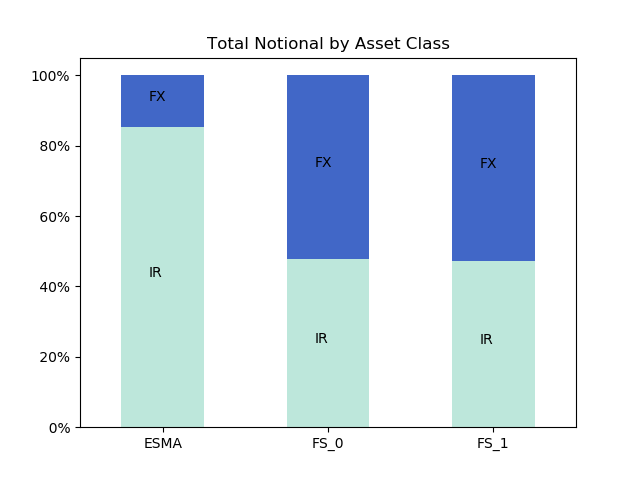

In [4]:
# calculate relative notionals
df_stat_ac_tt = df_npv[['AssetClass', 'Notional(Base)', 'FS']].groupby(['AssetClass', 'FS']).sum()
df_stat_ac_tt = df_stat_ac_tt / df_stat_ac_tt.groupby(level=[1]).sum()
df_stat_ac_tt = df_stat_ac_tt.unstack().T.reset_index(level=0, drop=True)
df_stat_ac_tt.index.names=['#']
df_stat_ac_tt['FS'] = ['FS_' + str(x) for x in df_stat_ac_tt.index]
df_stat_notional_tot_ac_pct = pd.DataFrame(data={'IR':[69/(69+12)], 'FX': [12/(69+12)], 'FS': ['ESMA']})
df_stat_ac_tt = pd.concat([df_stat_notional_tot_ac_pct, df_stat_ac_tt], sort=False, ignore_index=True)

fig, ax = plt.subplots()
df_stat_ac_tt.plot.bar(stacked=True, color=[cm.get_cmap('icefire')(1.*i/4) for i in range(0,2)], rot=0, ax=ax)
ax.set_xticklabels(df_stat_ac_tt['FS'])
ax.get_legend().remove()
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_title('Total Notional by Asset Class', fontsize=12)
asset_classes = ['IR', 'FX']
for rect, label in zip(ax.patches, [asset_classes[i] for i in range(len(asset_classes)) for j in range(df_stat_ac_tt.shape[0])]):
    ax.text(rect.get_x()+rect.get_width()/3, rect.get_y() + rect.get_height()/2, label)
plt.show()

## Trade NPV Distribution
We plot the distribution of NPVs in the bilateral system per asset class. We find that both distributions are symmetric. This makes perfect sense as the NPV flips sign when the trade is viewed from the counterparties perspective. We also find that the FX trades have a much wider distribution.

<IPython.core.display.Javascript object>


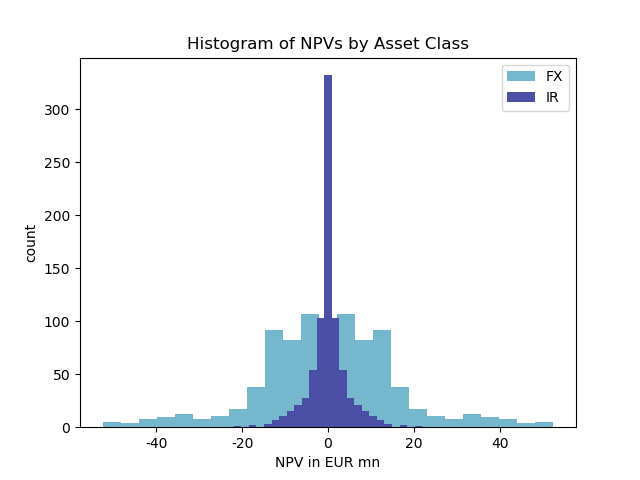

In [5]:
fig, ax = plt.subplots()
fs_id=0
df_npv_fs = df_npv[df_npv['FS']==fs_id]
df_npv_fs[df_npv_fs['TradeType']=='FxForward']['NPV(Base)'].hist(bins=25, label='FX', ax=ax, color=cm.get_cmap('icefire')(0.1))
df_npv_fs[df_npv_fs['TradeType']=='Swap']['NPV(Base)'].hist(bins=25, label='IR', ax=ax, color=cm.get_cmap('icefire')(0.3))
ax.grid(False)
ax.set_title('Histogram of NPVs by Asset Class')
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{:,.0f}".format(x/1000000)))
ax.set_ylabel("count")
ax.set_xlabel("NPV in EUR mn")
ax.legend()
plt.show()

# Average Impact of Regulation Across Systems
This graph shows the average impact of the tested regulations across all financial systems.

In [6]:
def to_reg(base_reg):
    if base_reg in ['bilateral', 'repartitioned']:
        return base_reg
    else:
        return base_reg+'_AAA'

@interact(metric=Dropdown(options = metrics), onlyAAA=Checkbox(value=False, description='only AAA'))
def draw_avg_impacts(metric, onlyAAA):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax.set_title('Average Impact Across Systems: '+metric, fontsize=12)
    if onlyAAA:
        regs_query = [to_reg(reg) for reg in regs_base]
        regs_labels = regs_base
    else:
        regs_query=regulations
        regs_labels = regulations
    df_sys_impact[[(reg,metric+'_total') for reg in regs_query]].mean().plot.bar(color=[mycmap(i/len(regs_query)) for i in range(len(regs_query))], rot=90, ax=ax)
    ax.set_xticklabels(regs_labels, fontsize=10)
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{:,.0f}".format(x/1000000)))
    ax.set_ylabel("EUR mn")
    fig.tight_layout()

interactive(children=(Dropdown(description='metric', options=('BaselEEPE', 'CVA'), value='BaselEEPE'), Checkbo…

# Total Impact of Regulation per System
Now, we drill down and show the aggregate impact of the regulation per financial system.

In [7]:
@interact(metric=Dropdown(options = metrics), onlyAAA=Checkbox(value=False, description='only AAA'))
def plot_total_impact_per_system(metric, onlyAAA):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    fig.subplots_adjust(right=0.7)
    if onlyAAA:
        regs_query = [to_reg(reg) for reg in regs_base]
        regs_labels = regs_base
    else:
        regs_query=regulations
        regs_labels = regulations
    ax.set_title('Total Impacts per System: '+metric, fontsize=12)
    df_sys_impact[[(reg,metric+'_total') for reg in regs_query]].plot.bar(color=[mycmap(i/len(regs_query)) for i in range(len(regs_query))], rot=0, ax=ax)
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{:,.0f}".format(x/1000000)))
    ax.set_ylabel("EUR mn")
    ax.set_xlabel("Financial System Index")    
    ax.legend(labels=regs_labels, loc='upper right', bbox_to_anchor=(1.5, 1))

interactive(children=(Dropdown(description='metric', options=('BaselEEPE', 'CVA'), value='BaselEEPE'), Checkbo…

# Impacts per Counterparty
Next, we drill down even further and show the impact of the regulation on individual counterparties in a financial system. We study absolute impacts of the top counterparties as well as relative impacts.

In [8]:
inout_label = {'+':'plus', '-':'minus'}

@interact(fs_id=Dropdown(options = financial_system_ids), 
                    metric=Dropdown(options = metrics),
                    inout=RadioButtons(options=['+', '-']),
                    onlyAAA=Checkbox(value=False, description='only AAA'))
def draw_cp_impacts(fs_id, metric, inout, onlyAAA):
    if onlyAAA:
        regs_query = [to_reg(reg) for reg in regs_base]
        regs_labels = regs_base
    else:
        regs_query = regulations
        regs_labels = regulations
    df_risk_cp_fs = df_risk_cp[df_risk_cp[('','FS')]==fs_id][[('','CP')]+[(reg,metric+inout) for reg in regs_query]]
    df_risk_cp_fs_no_cpp = df_risk_cp_fs[df_risk_cp_fs[('','CP')]>=0][[(reg,metric+inout) for reg in regs_query]+[('','CP')]]
    df_risk_cp_fs_cpp = df_risk_cp_fs[df_risk_cp_fs[('','CP')]<0][[(reg,metric+inout) for reg in regs_query]+[('','CP')]]

    # absolute impacts on banks
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 5)
    ax.set_title('Absolute Impacts per Counterparty (Top 3): '+metric+inout, fontsize=12)
    df_risk_cp_fs_no_cpp_top = df_risk_cp_fs_no_cpp.sort_values(('bilateral',metric+inout),ascending=False).head(3)
    df_risk_cp_fs_no_cpp_top.plot.bar(color=[mycmap(i/len(regs_query)) for i in range(len(regs_query))], rot=0, ax=ax, width=0.6)
    ax.set_xticklabels(df_risk_cp_fs_no_cpp_top['','CP'])
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{:,.0f}".format(x/1000000)))
    ax.set_ylabel("EUR mn")
    ax.set_xlabel("Counterparty Index")
    ax.legend(labels=regs_labels, loc='upper right', bbox_to_anchor=(1.5, 1.))
    fig.tight_layout()
    
    # relative impacts
    fig, ax = plt.subplots()
    fig.set_size_inches(13, 5)
    #fig.subplots_adjust(right=0.7)
    ax.set_title('Risk Concentration per Counterparty: '+metric+inout, fontsize=12)
    df_risk_cp[df_risk_cp[('','FS')]==fs_id][[('','CP')]+[(reg,metric+'_rho'+inout) for reg in regs_query]].set_index(('','CP')).T.plot.bar(stacked=True, cmap=cm.get_cmap('tab20c'), rot=90, ax=ax)
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:3.0f}%'.format(x*100)))
    ax.set_ylabel("concentration")
    ax.set_xlabel("regulation")
    ax.set_xticklabels(regs_labels, fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    split_index=16
    ax.add_artist( ax.legend(handles[split_index:], labels[split_index:], loc='upper left', bbox_to_anchor=(1.15, 1.022)))
    ax.legend(handles[:split_index], labels[:split_index], loc='upper right', bbox_to_anchor=(1.15, 1.022), title="CP index")
    fig.tight_layout()

interactive(children=(Dropdown(description='fs_id', options=(0, 1), value=0), Dropdown(description='metric', o…

# Data Mining: Relative Counterparty Impacts
We calculate the relative impact of any regulation compared to 'bilateral' on every counterparty (except the CCPs) and draw a histogram

## EEPE Counterparty Impacts
We can see that in terms of EEPE, pre-clearing has no impact on any given bank. In the cleared system, the EEPE goes down as the bank can realize cross-counterparty netting benefits, which cannot be realized in the bilateral system. The multi-pre-cleared, we can see that the risks can only go up as cross-asset netting benefits are lost. In the multi-cleared case, some cross-counterparty netting benefits are regained, but in total, the cleared system is much safer than the multi-cleared system. In particular, for the cleared system the risks can only go down as for the multi-cleared system, the risks can also go up.

<IPython.core.display.Javascript object>


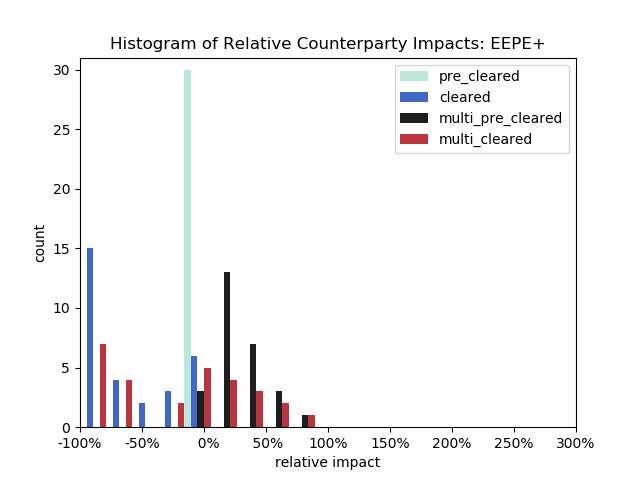

In [9]:
fs_id=0
regs_hist = ['pre_cleared', 'cleared', 'multi_pre_cleared', 'multi_cleared']
fig, ax = plt.subplots()
values = [df_risk_cp[df_risk_cp['','FS']==fs_id][[(to_reg(reg), 'BaselEEPE+_diff_rel')]].replace([np.inf, -np.inf]).dropna().values[:,0] for reg in regs_hist]
ax.hist(values, bins=np.linspace(-1,3,20), label=regs_hist, rwidth=5, color=[mycmap(i/len(regs_hist)) for i in range(len(regs_hist))])
ax.grid(False)
ax.set_title('Histogram of Relative Counterparty Impacts: EEPE+')
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:3.0f}%'.format(x*100)))
ax.set_ylabel("count")
ax.set_xlabel("relative impact")
ax.set_ylim([0, 31])
ax.set_xlim([-1, 3])
ax.legend()
plt.show()

## CVA Counterparty Impacts
We repeat the above analysis, but now with CVA as a metric. We can see the same effect, but we also see that the credit quality of the CCP has a substantial impact.

In [10]:
@interact(reg=Dropdown(options = regs_base[1:]),
          fs_id=Dropdown(options = financial_system_ids),
          metric=Dropdown(options = metrics),
          inout=RadioButtons(options=['+', '-']))
def draw_risk_cp_hist(reg, fs_id, metric, inout):
    fig, ax = plt.subplots()
    if reg=='repartitioned':
        df_risk_cp_hist = df_risk_cp[df_risk_cp['','FS']==fs_id][[(reg, metric+inout+'_diff_rel')]].replace([np.inf, -np.inf]).dropna()
        df_risk_cp_hist.hist(bins=np.linspace(-1,3,20), ax=ax, rwidth=0.5)
    else:
        ratings = ['AA', 'AAA', 'AAAA']
        values = [df_risk_cp[df_risk_cp['','FS']==fs_id][[(reg+'_'+rating, metric+inout+'_diff_rel')]].replace([np.inf, -np.inf]).dropna().values[:,0] for rating in ratings]
        ax.hist(values, bins=np.linspace(-1,3,20), rwidth=2, label=ratings, color=[cm.get_cmap('afmhot')(i/(len(ratings))) for i in range(len(ratings))])
        ax.legend()
    ax.grid(False)
    ax.set_title('Histogram of Relative Counterparty Impacts: ' + metric + inout)
    ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:3.0f}%'.format(x*100)))
    ax.set_ylabel("count")
    ax.set_xlabel("relative impact")
    ax.set_ylim([0, 31])
    ax.set_xlim([-1, 3])

interactive(children=(Dropdown(description='reg', options=('pre_cleared', 'cleared', 'repartitioned', 'multi_p…

## Netting Benefits EEPE
We compute the distriution of the netting benefits of the counterparties measured in EEPE. For the cleared system that is simply the amount of EEPE+ that each counterparty has less in the cleared system vs. the bilateral system. For the multi-cleared system we can see that the EEPE+ does not go down by that much and it also gets increased as a result of the cross-asset netting benefits.

<IPython.core.display.Javascript object>


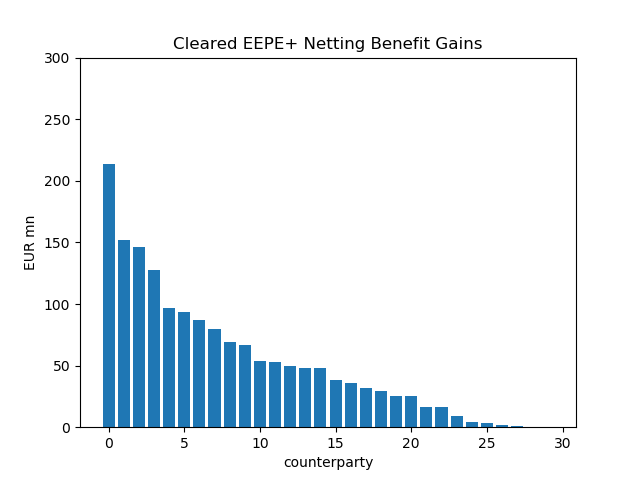

<IPython.core.display.Javascript object>


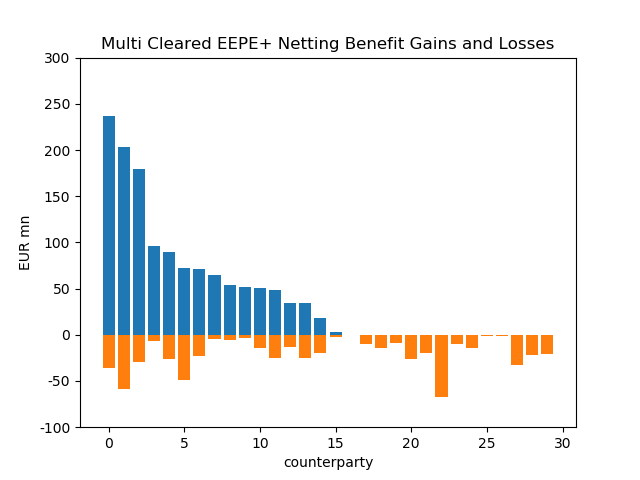

In [11]:
df_risk_cp['','nbf_cleared'] =  df_risk_cp[to_reg('pre_cleared'),'BaselEEPE+']-df_risk_cp[to_reg('cleared'),'BaselEEPE+'] 
df_risk_cp['','nbf_multi_cleared_gains'] =  df_risk_cp[to_reg('multi_pre_cleared'),'BaselEEPE+']-df_risk_cp[to_reg('multi_cleared'),'BaselEEPE+'] 
df_risk_cp['','nbf_multi_cleared_losses'] =  df_risk_cp['bilateral','BaselEEPE+']  - df_risk_cp['repartitioned','BaselEEPE+']

fs_id=0
df_risk_cp_fs = df_risk_cp[df_risk_cp[('','FS')]==fs_id].copy()

nbf_gains_cleared = df_risk_cp_fs[df_risk_cp_fs['','CP']>=0].sort_values(('','nbf_cleared'),ascending=False)['','nbf_cleared']
nbf_gains_multi_cleared = df_risk_cp_fs[df_risk_cp_fs['','CP']>=0].sort_values(('','nbf_multi_cleared_gains'),ascending=False)['','nbf_multi_cleared_gains']
nbf_losses_multi_cleared = df_risk_cp_fs[df_risk_cp_fs['','CP']>=0].sort_values(('','nbf_multi_cleared_gains'),ascending=False)['','nbf_multi_cleared_losses']

fig, ax = plt.subplots()
ax.bar(range(np.array(nbf_gains_cleared).shape[0]), np.array(nbf_gains_cleared))
ax.set_title('Cleared EEPE+ Netting Benefit Gains')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{:,.0f}".format(x/1000000)))
ax.set_xlabel("counterparty")
ax.set_ylabel("EUR mn")
ax.set_ylim([0, 300000000])

fig, ax = plt.subplots()
ax.bar(range(np.array(nbf_gains_cleared).shape[0]), np.array(nbf_gains_multi_cleared))
ax.bar(range(np.array(nbf_losses_multi_cleared).shape[0]), np.array(nbf_losses_multi_cleared))
ax.set_title('Multi Cleared EEPE+ Netting Benefit Gains and Losses')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: "{:,.0f}".format(x/1000000)))
ax.set_xlabel("counterparty")
ax.set_ylabel("EUR mn")
ax.set_ylim([-100000000, 300000000])
plt.show()